# Конструирование текстовых признаков из твитов пользователей

## Сбор данных

In [1]:
import pandas as pd
import numpy as np
import twitter
import matplotlib.pyplot as plt
import csv
#import time
import sys
import re

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
CONSUMER_KEY = "---"
CONSUMER_SECRET = "---"

ACCESS_TOKEN_KEY = "---"
ACCESS_TOKEN_SECRET =  "---"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [3]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users = df_users.reset_index(drop=True)
df_users.head()

,uid,cat
0,40585382,1.0
1,30005269,0.0
2,3314758074,0.0
3,14311688,0.0
4,110457801,0.0


In [6]:
df = pd.read_csv('tweets/tweets_all.csv', sep=',')

In [4]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    #добавить getsleeptime
    tweets = []
    timeline = api.GetUserTimeline(user_id, count=200)
    for i in timeline:
        d = i.AsDict()
        tweets.append({'lang': d['lang'], 
             'favorited': d['favorited'], 
             'truncated': d['truncated'], 
             'text': d['text'], 
             'created_at': d['created_at'], 
             'retweeted': d['retweeted'], 
             'source': d['source'], 
             'user': user_id, 
             'id': d['id']})
    return tweets

In [5]:
#сбор данных по всем твитам, дамп каждые 250 пользоватлей
tweets = []
i = 0
while True:
        if (i%250)==0:
            df = pd.DataFrame(tweets)
            OUT_FILE_PATH = "tweets/tweets_"+str(i)+".csv"
            df.to_csv(OUT_FILE_PATH, sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
        
        if i >= len(df_users.uid):
            df = pd.DataFrame(tweets)
            OUT_FILE_PATH = "tweets_last.csv"
            df.to_csv(OUT_FILE_PATH, sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
            break
        
        try:
            sleeptime = api.GetSleepTime('statuses/user_timeline')
        except Exception as e:
            print "Sleep for 60 sec"
            time.sleep(60)
            continue
        
        if sleeptime: time.sleep(sleeptime + 1)
        sys.stdout.write('\rTweets %.5f ' % (float(i)/len(df_users.uid)))
        sys.stdout.flush()
        
        try:
            user_tweets = get_user_tweets(uids[i])
            tweets += user_tweets
        except Exception as e:
            print e
        i += 1
        continue


Tweets 0.00000 name 'uids' is not defined
Tweets 0.00014 name 'uids' is not defined
Sleep for 60 sec


NameError: name 'time' is not defined

## Разбор текста твита

In [7]:
string = "new--york $one ;two ____twoo №___THRESADLKJL asdkaslidalkASLKD NKJLANkasnckasjdncasa ,. ,. ,/. ,/,. .,.,#123 \
        denilv_denilv №1023-++_+ http://asd.ru/asdijsad https://asdcx.dsacx.rqwe.sad/orasd \
        hello!my!dear?friend https://asd.rw"

In [8]:
def get_words(text):
    #text = re.sub('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub('-', '', text)
    text = re.sub('[^\w]', ' ',  text)
    text = re.sub('\d', '', text)
    text = re.sub('[_]', ' ', text)
    text = text.lower()
    return text.split()

In [9]:
print get_words(string)

['newyork', 'one', 'two', 'twoo', 'thresadlkjl', 'asdkaslidalkaslkd', 'nkjlankasnckasjdncasa', 'denilv', 'denilv', 'hello', 'my', 'dear', 'friend']


In [10]:
import nltk
from nltk.corpus import stopwords

In [11]:
# Приведение к нормальной форме
wnl = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
stop.append('via')
stop.append('amp')
stop.append('lot')

def get_tokens(words):
    """returns list of tokens"""
    for i in words:
        if (i not in stop) and (len(i)>2):
            respond.append(wnl.lemmatize(i))
    return respond

In [12]:
print get_tokens(["here", "are", "different", "words", "rt", "a"])

['different', u'word']


In [13]:
def get_tweet_tokens(tweet):
    words = get_words(tweet)
    tokens = get_tokens(words)
    return tokens

In [14]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    counters = []
    for num, uid in enumerate(df_users.uid.tolist()):
        sys.stdout.write('\rUsers %.5f ' % (float(num)/len(df_users)))
        sys.stdout.flush()
        user_counter = Counter()
        tmp_df = df[df['user']=="{u'id': " + str(uid) + "}"]
        for j, i in tmp_df.iterrows():
            toks = get_tweet_tokens(i['text']) #i[7] - text of the current tweet
            for word in toks:
                user_counter[word] += 1
        counters.append(user_counter)
    sys.stdout.write('\rUsers 1.00000')
    return df_users.uid.tolist(), counters

In [15]:
from collections import Counter

In [ ]:
users, users_tokens = collect_users_tokens(df_users)

In [17]:
from sklearn.feature_extraction import DictVectorizer

In [18]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [19]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

In [20]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread

In [21]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    s = vs.sum(0).tolist()[0]
    a = zip(v.get_feature_names(), s)
    img = imread('usa1.png')
    image_colors = ImageColorGenerator(img)
    wc = WordCloud(background_color="black", mask=img, stopwords=STOPWORDS, font_path='TNR.ttf')
    wc.generate_from_frequencies(a)
    plt.imshow(wc.recolor(color_func=image_colors))
    plt.axis("off")
    plt.savefig('tagcloud.jpg', dpi=300)
    plt.show()
    return

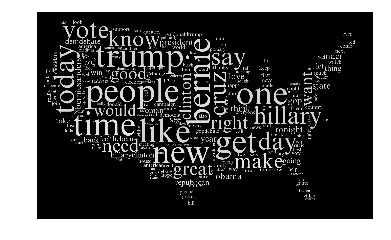

In [22]:
draw_tag_cloud(v, vs)